# ArchiCrop tutorial - Sorghum

This notebook is a tutorial for executing ArchiCrop model for sorghum.

## 0. Imports

In [1]:
from __future__ import annotations

import sys
sys.path.append('../data')
import numpy as np
from oawidgets.plantgl import *  # noqa: F403

from openalea.archicrop.archicrop import ArchiCrop
from openalea.archicrop.display import build_scene, display_scene
from openalea.archicrop.stics_io import read_sti_file, read_xml_file
from openalea.plantgl.all import Color3, Material, Scene

%gui qt

## 1. Retrieve crop model parameters about management

Retrieve crop model parameters regarding the spatial (and temporal) configuration of the crop.

In [2]:
file_tec_xml = '../data/sorgho_tec.xml'
params_tec = ['densitesem', 'interrang']
tec_stics = read_xml_file(file_tec_xml, params_tec)
sowing_density = tec_stics['densitesem']
inter_row = 40

## 2. Retrieve crop model growth and senescence dynamics

From crop-scale data either measured or simulated with a crop model, generate a dictionnary of dictionnaries for each day with the following values :
 - "Thermal time" (float): cumulated thermal time from beginning of simulation to current day (in °C.day)
 - "Phenology" (str): current phenological stage (germination, juvenile, exponential or repro)
 - "Plant leaf area" (float): plant leaf area (in cm²) 
 - "Leaf area increment" (float): leaf area increment compared to previous day (in cm²) 
 - "Plant senescent leaf area" (float): senescent plant leaf area (in cm²) 
 - "Senescent leaf area increment" (float): senescent leaf area increment compared to previous day (in cm²) 
 - "Plant height" (float): plant height (in cm) 
 - "Height increment" (float): height increment compared to previous day (in cm).

In [3]:
stics_output_file = '../data/mod_ssorghum.sti'
daily_dynamics = read_sti_file(stics_output_file, sowing_density)

# Time series 
# for thermal time, plant leaf area, plant senescent leaf area and plant height
dates = [value["Date"] for value in daily_dynamics.values()]
thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
height_canopy = [value["Plant height"] for value in daily_dynamics.values()]

## 3. Set plant architectural parameters

Set topological, geometrical and developmental parameters, in a range corresponding a given species, found in literature.

In [17]:
# TODO : verify the values in literature
nb_phy=15 # number of phytomers on the main stem : [10,40] (Ndiaye et al., 2021; Lafarge and Tardieu, 2002; Clerget, 2008; Ganeme et al., 2022)

# Stem
height=1*max(height_canopy) # potential plant height : [50,400] (Ganeme et al., 2022; Nebie et al., 2013)
stem_q=1.1 # parameter for ligule height distribution along axis : [1.1] (Kaitaniemi et al., 1999) 
diam_base=2.5 # stem base diameter : [2.2] (Ndiaye et al., 2021)
diam_top=1.5 # stem top diameter: [1.2] (Ndiaye et al., 2021)

# Leaf blade area 
leaf_area=1*max(leaf_area_plant) # potential plant leaf area : [] (Clerget, 2008)
rmax=0.7 # parameter for leaf area distribution along axis : [0.6,0.8] (Kaitaniemi et al., 1999; Welcker et al., )
skew=0.005 # parameter for leaf area distribution along axis : [] (Kaitaniemi et al., 1999; Welcker et al., )
wl=0.12 # leaf blade width-to-length ratio : [0.1, 0.12] ()
klig=0.6 # parameter for leaf blade shape
swmax=0.55 # parameter for leaf blade shape
f1=0.64 # parameter for leaf blade shape
f2=0.92 # parameter for leaf blade shape

# Leaf blade position in space
insertion_angle=30 # leaf blade insertion angle : [10,50] (Truong et al., 2015; Kaitaniemi et al., 1999)
scurv=0.7 # leaf blade relative inflexion point : [0.6, 0.8] ()
curvature=90 # leaf blade insertion-to-tip angle : [45, 135] (Kaitaniemi et al., 1999)
phyllotactic_angle=180 # phyllotactic angle : [180] (Davis et al., 2024)
phyllotactic_deviation=10 # half-deviation to phyllotactic angle : [0,90] (Davis et al., 2024)

# Development
phyllochron=40 # phyllochron, i.e. stem element appearance rate : [40,65 then x1.6-2.5] (Clerget, 2008)
plastochron=42 # plastochron, i.e. leaf blade appearance rate : [34,46 then 80-93] (Rami Kumar et al., 2009)

# Senescence (from crop model parameters)
file_plt_xml = '../data/proto_sorghum_plt.xml'
params_sen = ['durvieF', 'ratiodurvieI']
sen_stics = read_xml_file(file_plt_xml, params_sen)
lifespan = sen_stics['durvieF'] # leaf lifespan from appearance in exponential phase
lifespan_early = sen_stics['ratiodurvieI'] * lifespan # leaf lifespan from appearance in juvenile phase
leaf_lifespan=[lifespan_early, lifespan]

# Tillering
nb_tillers=2 # number of tillers : [0,6] (Lafarge et al., 2002)
tiller_angle=20
tiller_delay=1 # delay, as factor of phyllochron, between the appearance of a phytomer and the appearance of its tiller : [] ()
reduction_factor=0.7 # reduction factor between tillers of consecutive order : [] ()

## 4. Instantiate ArchiCrop object

In [18]:
sorghum = ArchiCrop(height=height, 
                  nb_phy=nb_phy,
                  leaf_area=leaf_area,
                  wl=wl, diam_base=diam_base, diam_top=diam_top, 
                  insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, 
                  klig=klig, swmax=swmax, f1=f1, f2=f2, 
                  stem_q=stem_q, rmax=rmax, skew=skew,
                  phyllotactic_angle=phyllotactic_angle,
                  phyllotactic_deviation=phyllotactic_deviation,
                  phyllochron=phyllochron, 
                  plastochron=plastochron, 
                  leaf_lifespan=leaf_lifespan,
                  nb_tillers=nb_tillers, tiller_delay=tiller_delay, tiller_angle=tiller_angle, reduction_factor=reduction_factor,
                  daily_dynamics=daily_dynamics)

## 5. Generate a potential plant 

Generate a potential plant from architectural parameters. 

This creates an MTG (Multi-scale Tree Graph, cf [doc](https://mtg.readthedocs.io/en/latest/user/tutorial.html)) as a property of the object plant.

In [19]:
sorghum.generate_potential_plant()
g = sorghum.g

In [20]:
# Print leaf area of all leaves, axis by axis
la_per_axis = {}
i = 0
for vid in g.vertices(scale=2):  # scale=2 corresponds to axes
    leaf_areas = []
    axis_label = g.parent(vid)
    print(f"Axis {axis_label}: {len(g.components(vid))/2} leaves")
    for leaf_vid in g.components(vid):
        if g.label(leaf_vid) == "Leaf":
            la = g.property("leaf_area")[leaf_vid]
            # la = g.property("mature_length")[leaf_vid]
            print(f"  Leaf {leaf_vid}: area = {la}")
            leaf_areas.append(la)
    la_per_axis[vid] = leaf_areas
    i += 1

Axis None: 15.0 leaves
  Leaf 4: area = 9.653259233287098
  Leaf 6: area = 15.381339639972891
  Leaf 8: area = 24.164525686994267
  Leaf 10: area = 37.079646744813964
  Leaf 12: area = 55.05228899321971
  Leaf 14: area = 78.34421512985277
  Leaf 16: area = 105.86186166610078
  Leaf 18: area = 134.54960907192236
  Leaf 20: area = 159.34738965061962
  Leaf 22: area = 174.19526538272743
  Leaf 24: area = 174.12691273747564
  Leaf 26: area = 157.667758502633
  Leaf 28: area = 128.10810497467682
  Leaf 30: area = 92.52867018906039
  Leaf 32: area = 58.85065682142219
Axis 2: 14.0 leaves
  Leaf 35: area = 6.980467547782038
  Leaf 37: area = 11.485089191047342
  Leaf 39: area = 18.563908040045792
  Leaf 41: area = 29.13789770547095
  Leaf 43: area = 43.900491567016765
  Leaf 45: area = 62.75834877520212
  Leaf 47: area = 84.14594327882217
  Leaf 49: area = 104.5979085884387
  Leaf 51: area = 119.15425482220678
  Leaf 53: area = 122.95931596507857
  Leaf 55: area = 113.61802736954674
  Leaf 57:

3175.1000000000004
3175.1


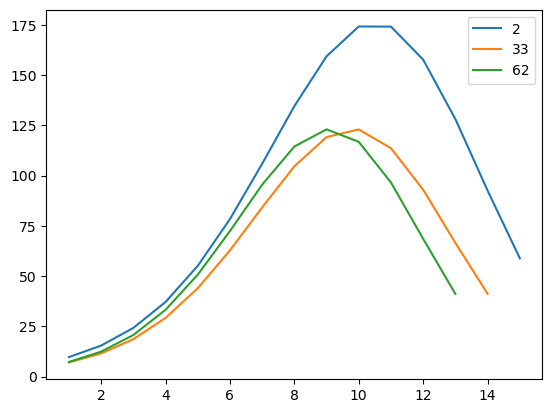

In [21]:
import matplotlib.pyplot as plt
total_area = 0.0
for key, value in la_per_axis.items():
    total_area += sum(value)
    plt.plot(range(1,len(value)+1), value, label=f"{key}")
print(total_area)
print(leaf_area)
plt.legend()
plt.show()

In [22]:
g.node(88).mature_length

97.31466598109184

In [23]:
axes = g.vertices(scale=2)
axis_orders = {axis: g.order(axis) for axis in axes}
axis_orders

{2: 0, 33: 1, 62: 1}

In [24]:
import oawidgets.mtg
oawidgets.mtg.plot(g)

mtg.html


In [25]:
for vid in g.vertices(scale=2):  # scale=2 corresponds to axes
    axis_label = g.label(vid)
    print(f"Axis {axis_label}:")
    for leaf_vid in g.components(vid):
        if g.label(leaf_vid) == "Leaf":
            leaf_area = g.property("leaf_area")[leaf_vid]
            print(f"  Leaf {leaf_vid}: area = {leaf_area}")

Axis MainAxis:
  Leaf 4: area = 9.653259233287098
  Leaf 6: area = 15.381339639972891
  Leaf 8: area = 24.164525686994267
  Leaf 10: area = 37.079646744813964
  Leaf 12: area = 55.05228899321971
  Leaf 14: area = 78.34421512985277
  Leaf 16: area = 105.86186166610078
  Leaf 18: area = 134.54960907192236
  Leaf 20: area = 159.34738965061962
  Leaf 22: area = 174.19526538272743
  Leaf 24: area = 174.12691273747564
  Leaf 26: area = 157.667758502633
  Leaf 28: area = 128.10810497467682
  Leaf 30: area = 92.52867018906039
  Leaf 32: area = 58.85065682142219
Axis Axis:
  Leaf 35: area = 6.980467547782038
  Leaf 37: area = 11.485089191047342
  Leaf 39: area = 18.563908040045792
  Leaf 41: area = 29.13789770547095
  Leaf 43: area = 43.900491567016765
  Leaf 45: area = 62.75834877520212
  Leaf 47: area = 84.14594327882217
  Leaf 49: area = 104.5979085884387
  Leaf 51: area = 119.15425482220678
  Leaf 53: area = 122.95931596507857
  Leaf 55: area = 113.61802736954674
  Leaf 57: area = 92.925641

In [26]:
scene, _ = build_scene(g)
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## 6. Simulate growth and senescence of the plant

Simulate growth and senescence of this plant following the daily dynamics.

In [27]:
growing_plant = sorghum.grow_plant()
# g = growing_plant[dates[-1]]

## 7. Plot 3D scene

In [28]:
times = [t for i,t in enumerate(thermal_time) if i%5 == 0]
mean_time = sum(times) / len(times)
positions = [ (0, 1*(t-mean_time), 0) for t in times]
nice_green = Color3((50, 100, 0))
scene, _ = build_scene([g for i,g in enumerate(list(growing_plant.values())) if i%5 == 0], position=positions, senescence=True, leaf_material = Material(nice_green), stem_material=Material(nice_green))
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [29]:
import oawidgets.mtg
oawidgets.mtg.plot(g)

mtg.html
